In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import xarray as xr
#from scipy.signal import savgol_filter
#import geopandas as gpd

#### Upload demand log data and refine out the random times

In [2]:
# dataframe for demand log
df_demand_log = pd.read_excel('FruitSoul Demand Log Fixed.xlsx')
df_demand_log['Earliest Delivery Date'] = df_demand_log['Earliest Delivery Date'].dt.date
df_demand_log['Preferred Delivery Date'] = df_demand_log['Preferred Delivery Date'].dt.date
df_demand_log['Latest Delivery Date'] = df_demand_log['Latest Delivery Date'].dt.date
df_demand_log_temp = df_demand_log.copy()
df_demand_log

,DemandID,Demand Request Date,Mix,Jar Size (vol. ounces),State,Quantity,Earliest Delivery Date,Preferred Delivery Date,Latest Delivery Date
0,1,2021-01-01,Apple-Mango,8,Maryland,1,2021-01-01,2021-01-04,2021-01-07
1,2,2021-01-01,Blueberry-Lemon,32,Kentucky,1,2021-01-04,2021-01-06,2021-01-09
2,3,2021-01-01,Orange-Passionfruit,16,Minnesota,1,2021-01-07,2021-01-10,2021-01-11
3,4,2021-01-01,Orange-Passionfruit,16,California,1,2021-01-07,2021-01-11,2021-01-14
4,5,2021-01-01,Orange-Passionfruit,32,Louisiana,1,2021-01-01,2021-01-04,2021-01-10
...,...,...,...,...,...,...,...,...,...
835374,835375,2023-12-31,Orange-Passionfruit,32,Arizona,1,2023-12-31,2024-01-05,2024-01-13
835375,835376,2023-12-31,Peach-Raspberry,32,California,1,2023-12-31,2024-01-01,2024-01-01
835376,835377,2023-12-31,Blueberry-Lemon,16,Arizona,1,2023-12-31,2024-01-02,2024-01-02
835377,835378,2023-12-31,Strawberry-Kiwi,8,California,1,2023-12-31,2024-01-03,2024-01-03


##### Filtered demand by earliest, preferred, and latest delivery date

In [7]:
# Filter the dataframe to each delivery date type
filtered_df_preferred_equals_earliest = df_demand_log[(df_demand_log['Preferred Delivery Date'] == df_demand_log['Earliest Delivery Date'])]
filtered_df_preferred_equals_latest = df_demand_log[(df_demand_log['Preferred Delivery Date'] == df_demand_log['Latest Delivery Date'])]
filtered_df_preferred_is_neither = df_demand_log[(df_demand_log['Preferred Delivery Date'] != df_demand_log['Earliest Delivery Date']) & 
                                                 (df_demand_log['Preferred Delivery Date'] != df_demand_log['Latest Delivery Date'])]

# Create a pivot table indexed by preferred delivery date
pivot_preferred_delivery_date = filtered_df_preferred_is_neither.pivot_table(index='Preferred Delivery Date', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_earliest_delivery_date = filtered_df_preferred_equals_earliest.pivot_table(index='Earliest Delivery Date', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_latest_delivery_date = filtered_df_preferred_equals_latest.pivot_table(index='Latest Delivery Date', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

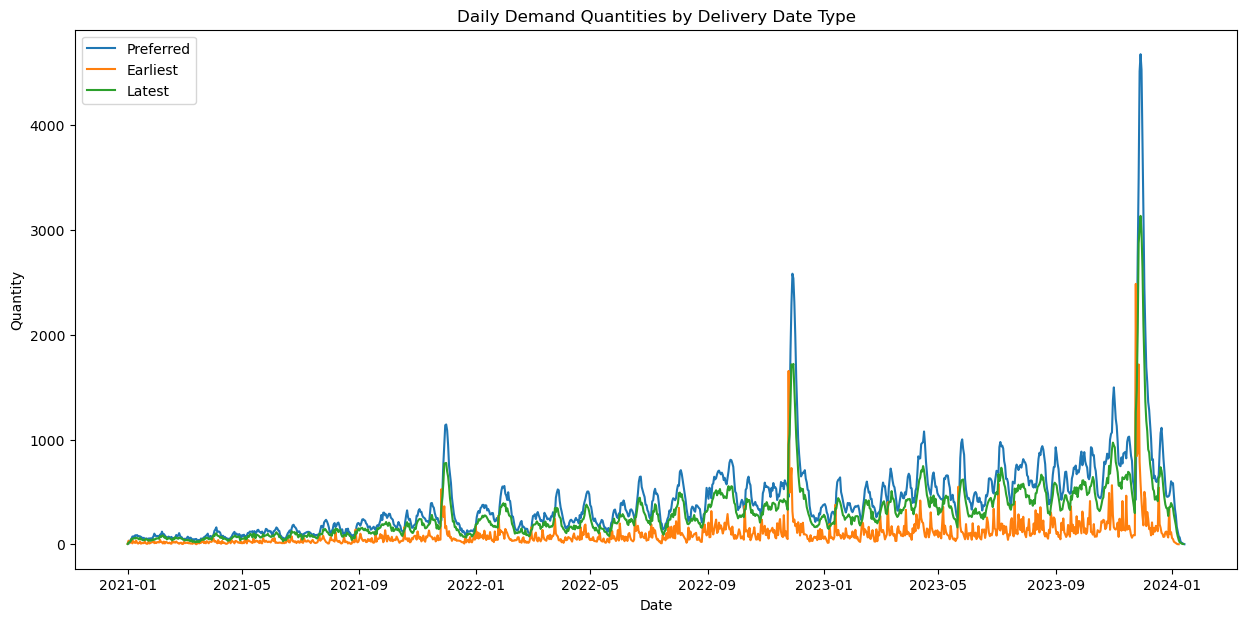

In [8]:
# Plot all three pivot tables on the same graph
plt.figure(figsize=(15, 7))
plt.plot(pivot_preferred_delivery_date.index, pivot_preferred_delivery_date['Quantity'], label='Preferred')
plt.plot(pivot_earliest_delivery_date.index, pivot_earliest_delivery_date['Quantity'], label='Earliest')
plt.plot(pivot_latest_delivery_date.index, pivot_latest_delivery_date['Quantity'], label='Latest')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Daily Demand Quantities by Delivery Date Type')
plt.legend()
plt.show()

#### Total quantity by demand request date

<Axes: xlabel='Demand Request Date'>

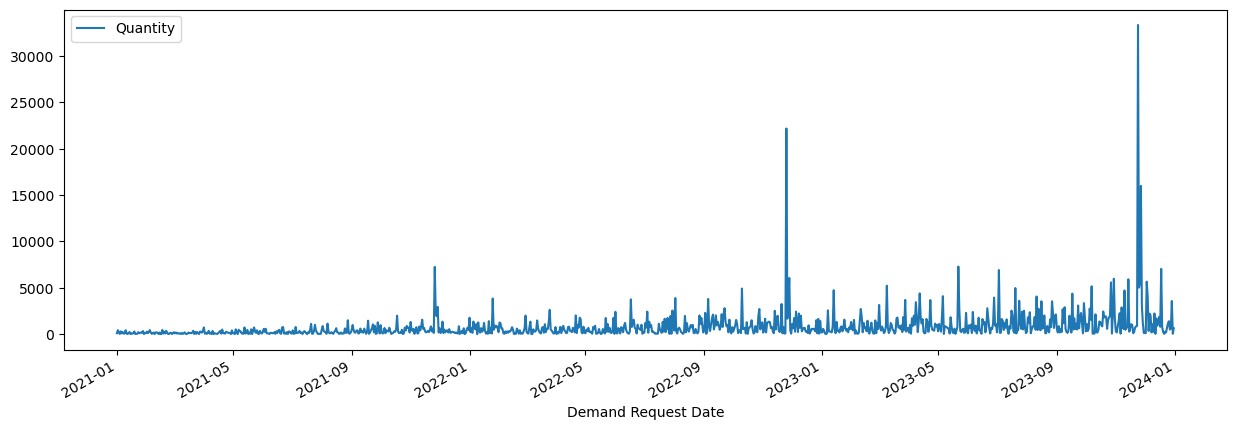

In [8]:
# Make a pivot table for over demand request date
pivot_demand_request_date = df_demand_log.pivot_table(index='Demand Request Date', 
                                        values='Quantity', aggfunc='sum', fill_value=0)

pivot_demand_request_date.plot(kind='line', figsize=(15, 5))

In [3]:
# Make a pivot table for over demand request date
pivot_demand_request_date_by_mix = df_demand_log.pivot_table(index='Demand Request Date', 
                                        columns=['Mix', 'Jar Size  (vol. ounces)'], 
                                        values='Quantity', aggfunc='sum', fill_value=0)

#### Daily demand request date for each mix and jar size

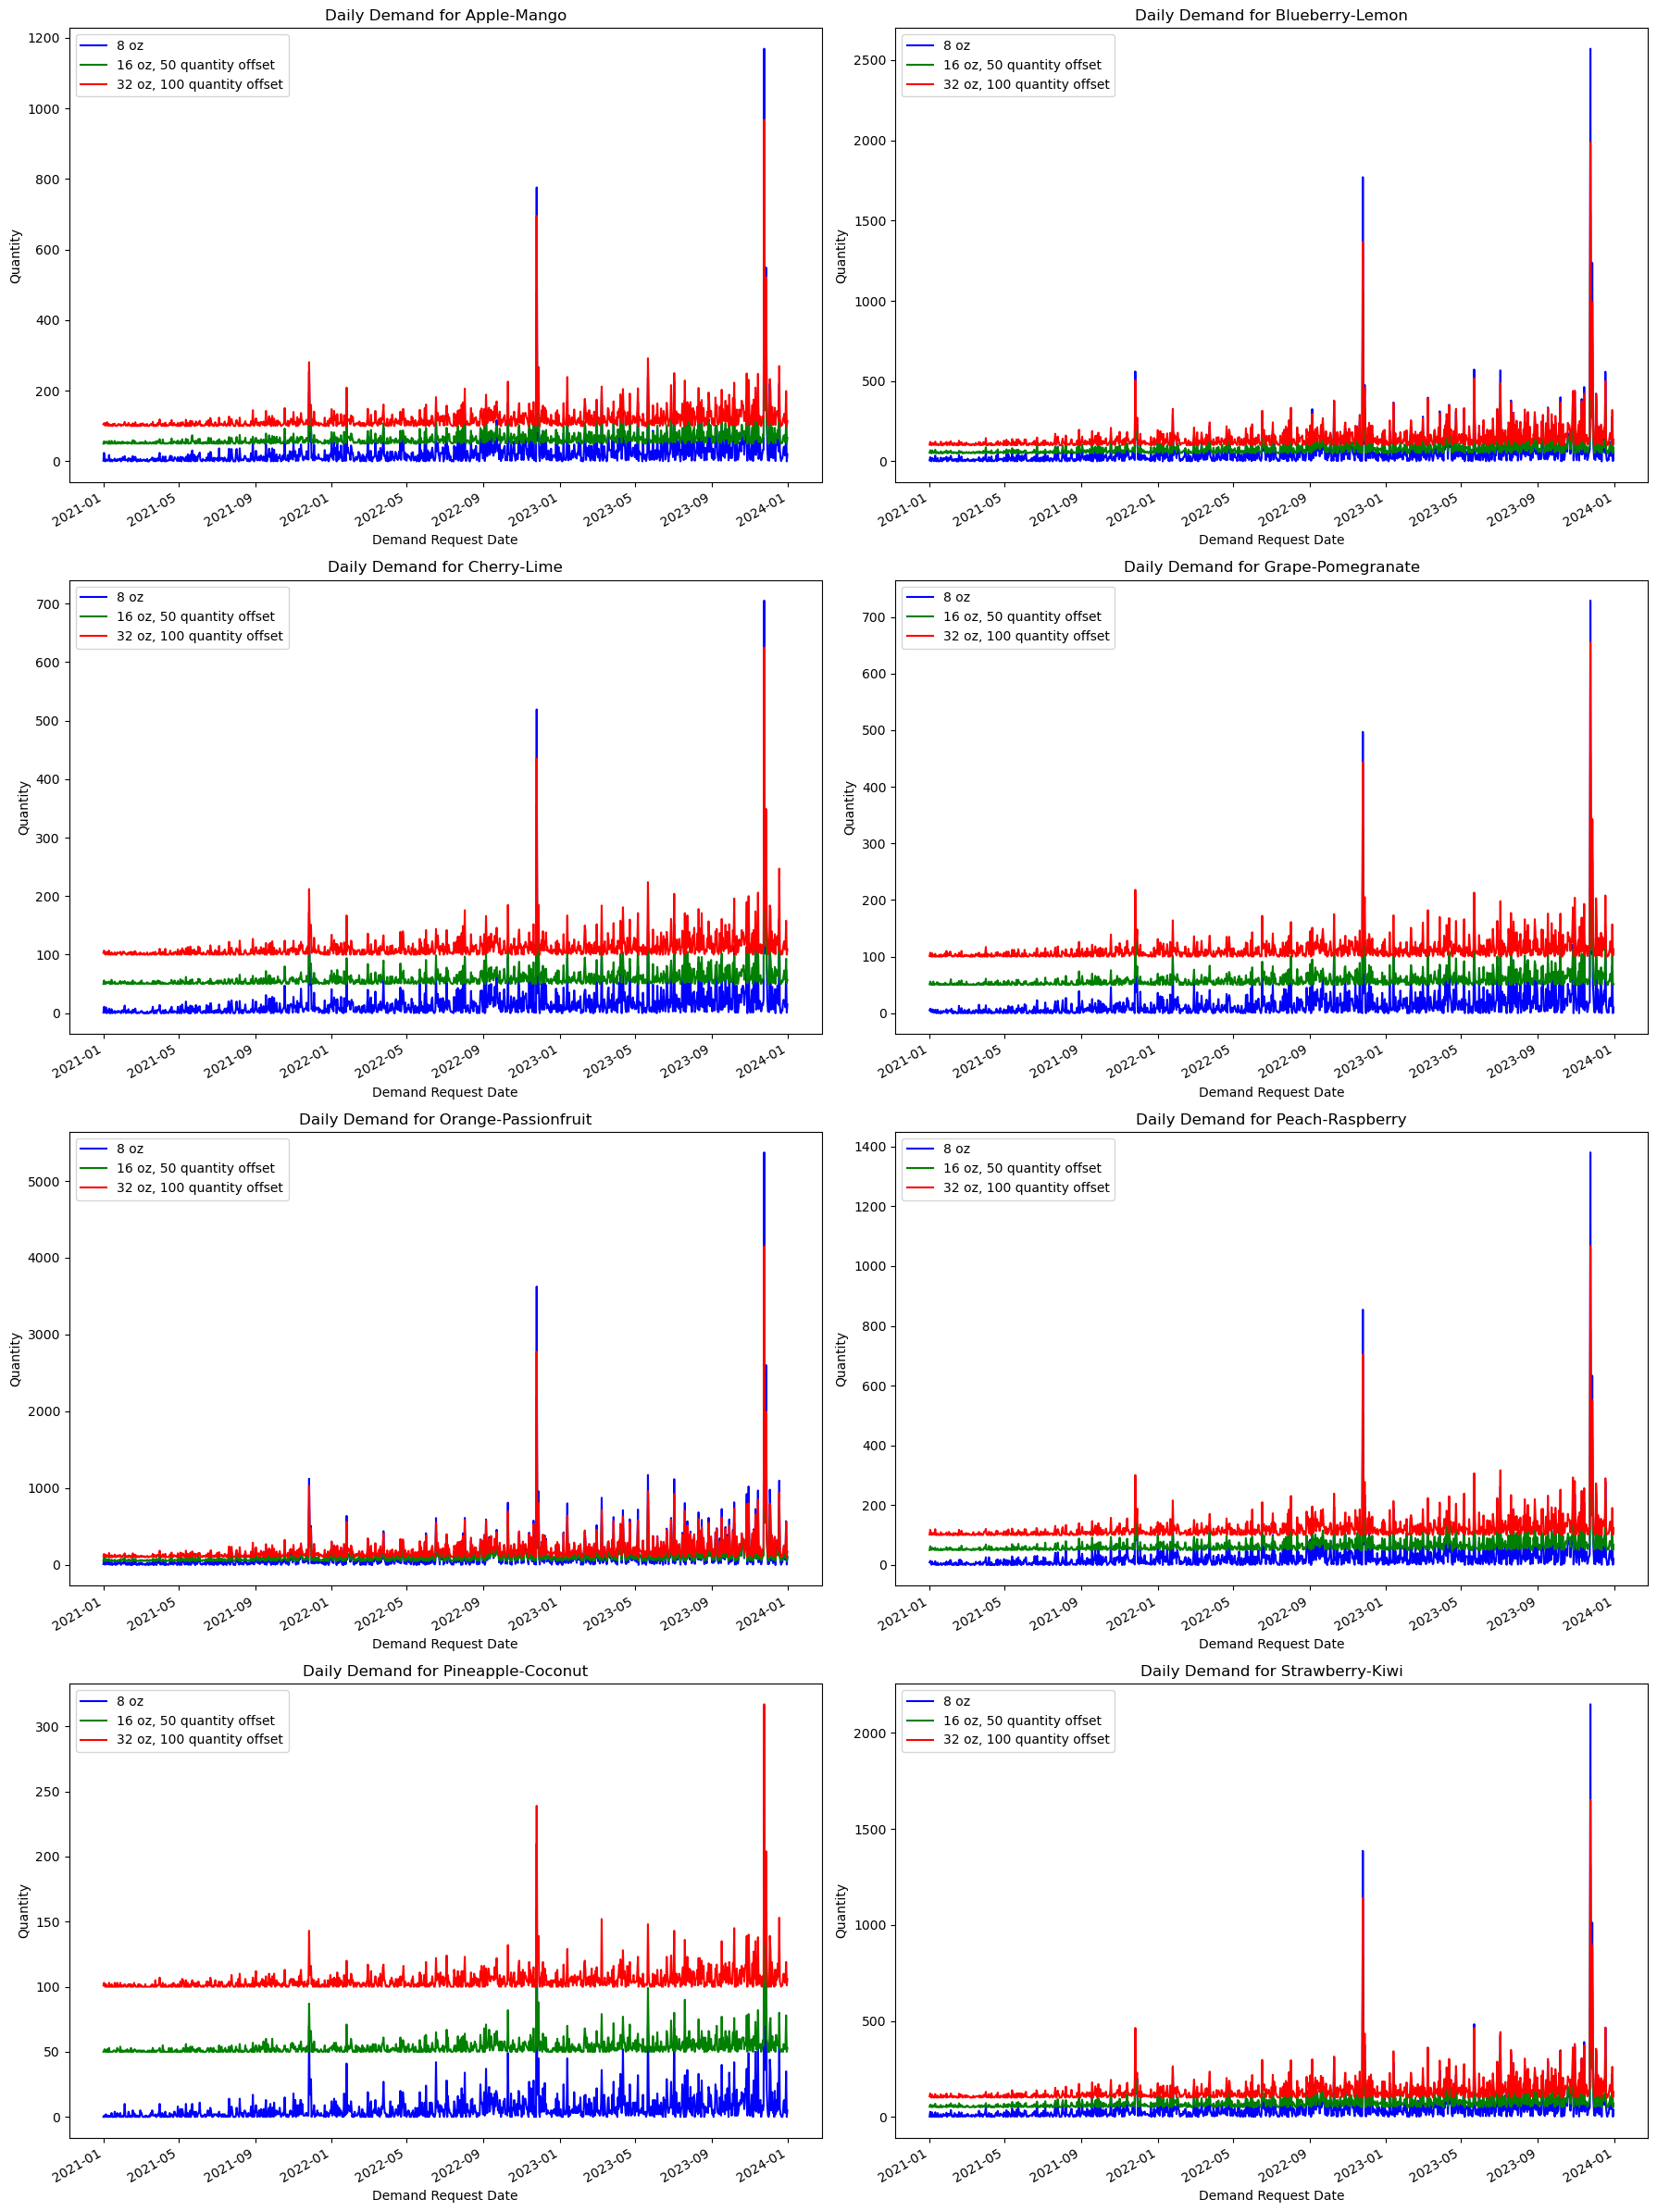

In [18]:
# Create the subplots with a 4x2 structure
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 24))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define colors for each jar size
colors = ['blue', 'green', 'red']

i = 0
for n, mix in enumerate(pivot_demand_request_date_by_mix.columns.levels[0]):
    # Plot with vertical offsets and specified colors
    pivot_demand_request_date_by_mix[(mix, 8)].add(0).plot(ax=axes[i], label='8 oz', color=colors[0])
    pivot_demand_request_date_by_mix[(mix, 16)].add(50).plot(ax=axes[i], label='16 oz, 50 quantity offset', color=colors[1])
    pivot_demand_request_date_by_mix[(mix, 32)].add(100).plot(ax=axes[i], label='32 oz, 100 quantity offset', color=colors[2])

    # Add labels and title
    axes[i].set_xlabel('Demand Request Date')
    axes[i].set_ylabel('Quantity')
    axes[i].set_title(f'Daily Demand for {mix}')
    axes[i].legend()
    i += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#### Quantity of mix and jar size by demand request date, on a weekly basis 

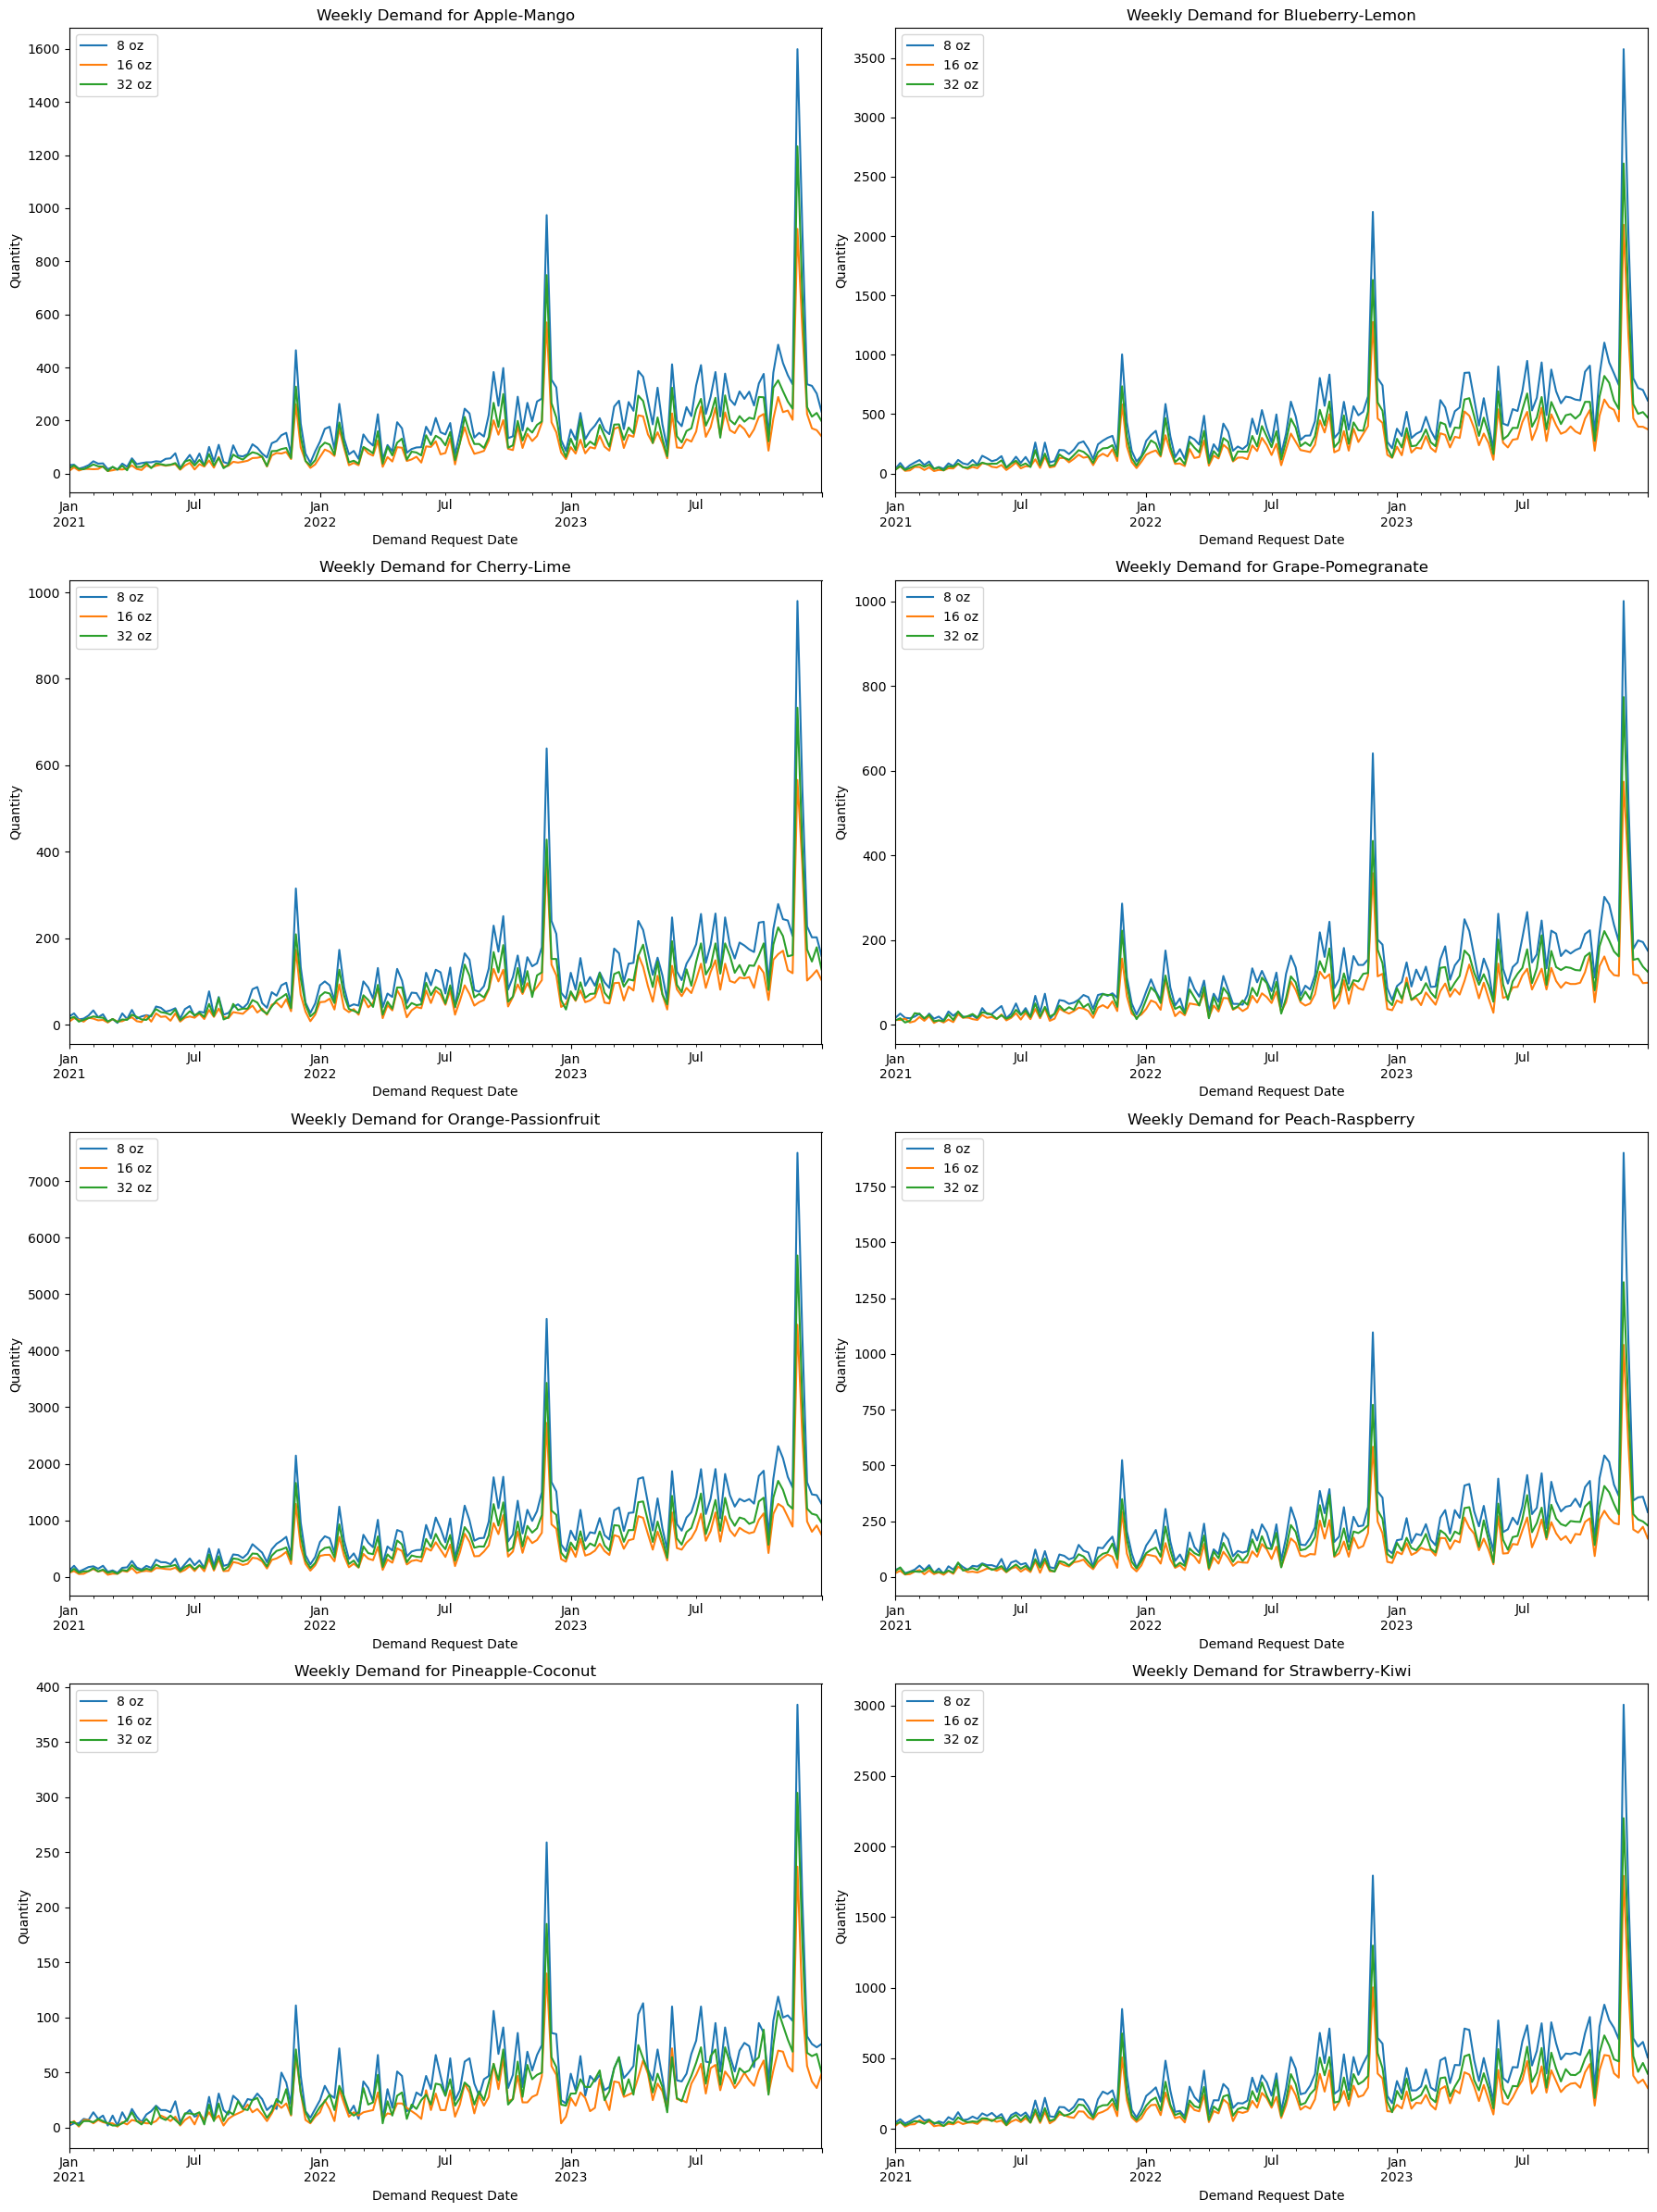

In [52]:
# Resample the pivot table to weekly
pivot_demand_request_date_by_mix_weekly = pivot_demand_request_date_by_mix.resample('W').sum()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 24))

# Flatten the axes array for easy iteration
axes = axes.flatten()

i = 0
for n, mix in enumerate(pivot_demand_request_date_by_mix_weekly.columns.levels[0]):
    # Plot
    pivot_demand_request_date_by_mix_weekly[(mix, 8)].plot(ax=axes[i], label='8 oz')
    pivot_demand_request_date_by_mix_weekly[(mix, 16)].plot(ax=axes[i], label='16 oz')
    pivot_demand_request_date_by_mix_weekly[(mix, 32)].plot(ax=axes[i], label='32 oz')

    # Add labels and title
    axes[i].set_xlabel('Demand Request Date')
    axes[i].set_ylabel('Quantity')
    axes[i].set_title(f'Weekly Demand for {mix}')
    axes[i].legend()
    i += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#### Smoothing by removing weekly fluctuations (in progress)

In [22]:
# add a new column to df_demand_log_temp for the day of the week
df_demand_log_temp['Demand Request Day'] = df_demand_log_temp['Demand Request Date'].dt.day_name()

# group by the day of the week and sum the quantity
dseries_demand_log_weekly = df_demand_log_temp.groupby('Demand Request Day')['Quantity'].sum()

# Create a dataseries for the proportion of demand for each day of the week
total_quantity = df_demand_log['Quantity'].sum()

dseries_demand_log_weekly_temp = dseries_demand_log_weekly.copy()
dseries_demand_log_weekly_temp = dseries_demand_log_weekly_temp.astype(float)
for day in dseries_demand_log_weekly.index:
    dseries_demand_log_weekly_temp[day] = dseries_demand_log_weekly_temp[day]/total_quantity

#print(dseries_demand_log_weekly_temp)

# Calculate the average demand share per day
average_demand_share_per_day = 1/7

# adjust demand share to be percent around the average
for day in dseries_demand_log_weekly.index:
    dseries_demand_log_weekly_temp[day] = dseries_demand_log_weekly_temp[day] - average_demand_share_per_day

dseries_demand_log_weekly_proportion = dseries_demand_log_weekly_temp
dseries_demand_log_weekly_proportion

Demand Request Day
Friday       0.064241
Monday       0.032924
Saturday    -0.010880
Sunday      -0.011857
Thursday    -0.025439
Tuesday     -0.015327
Wednesday   -0.033661
Name: Quantity, dtype: float64

<Axes: xlabel='Demand Request Date'>

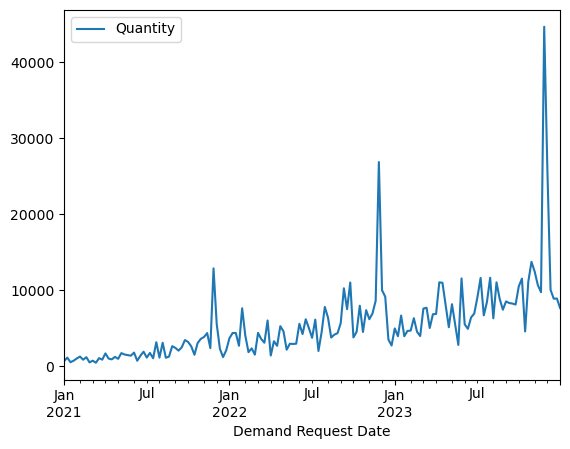

In [23]:
# Pivot table for demand request date
df_demand_log_temp = df_demand_log.copy()
pivot_table_temp = df_demand_log_temp.pivot_table(index='Demand Request Date', 
                                             values='Quantity', aggfunc='sum', fill_value=0)

# Adjust demand history for the proportion of demand for each day of the week
pivot_table_divided = pivot_table_temp.copy()
pivot_table_divided = pivot_table_divided.astype(float)
for date in pivot_table_divided.index:
    day_of_week = date.strftime('%A')
    proportion = dseries_demand_log_weekly_proportion[day_of_week]
    pivot_table_divided.loc[date] /= (1 + proportion)


pivot_table_divided = pivot_table_divided.resample('W').sum()
pivot_table_divided.plot()

In [41]:
pivot_table_temp = df_demand_log_temp.pivot_table(index='Demand Request Date', 
                                             values='Quantity', aggfunc='sum', fill_value=0)
pivot_table_temp['Day of Week'] = pivot_table_temp.index.day_name()

pivot_table_temp['Week Number'] = (pivot_table_temp.index - pivot_table_temp.index[0]).days // 7 + 1

pivot_days_by_week_number = pivot_table_temp.pivot_table(index='Week Number', columns='Day of Week', values='Quantity', aggfunc='sum', fill_value=0)
pivot_days_by_week_number
# Append seven columns with the proportion each day has on the whole week's quantities
for day in dseries_demand_log_weekly_proportion.index:
    pivot_days_by_week_number[day + ' Proportion'] = pivot_days_by_week_number[day] / pivot_days_by_week_number.sum(axis=1)

pivot_days_by_week_number.head()

Day of Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Friday Proportion,Monday Proportion,Saturday Proportion,Sunday Proportion,Thursday Proportion,Tuesday Proportion,Wednesday Proportion
Week Number,,,,,,,,,,,,,,
1,90,16,420,178,213,294,78,0.069822,0.012412,0.325813,0.138048,0.165174,0.227958,0.060468
2,57,57,60,419,227,12,102,0.061028,0.061024,0.064231,0.448519,0.242876,0.012836,0.109104
3,5,84,83,50,28,281,15,0.009158,0.153844,0.151969,0.091522,0.051244,0.514221,0.027424
4,35,136,209,89,326,180,139,0.031418,0.122079,0.187586,0.079868,0.292529,0.161476,0.124678
5,6,260,123,114,431,100,210,0.004823,0.209002,0.098858,0.091617,0.346350,0.080337,0.168698


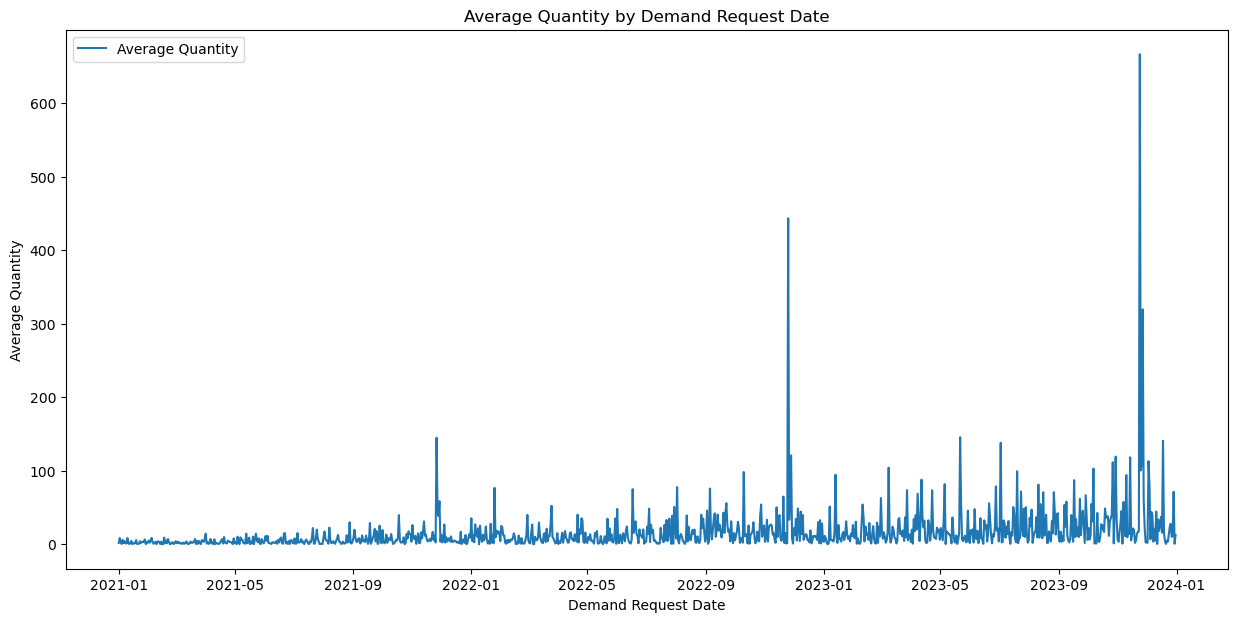

In [11]:
# Create a pivot table indexed by demand request date with all states
pivot_demand_request_date_states = df_demand_log.pivot_table(index='Demand Request Date', 
                                                             columns='State', 
                                                             values='Quantity', 
                                                             aggfunc='sum', 
                                                             fill_value=0)

#pivot_demand_request_date_states
pivot_demand_request_date_states['Average'] = pivot_demand_request_date_states.mean(axis=1)

# Plot demand request date on the x-axis and average on the y-axis
plt.figure(figsize=(15, 7))
plt.plot(pivot_demand_request_date_states.index, pivot_demand_request_date_states['Average'], label='Average Quantity')
plt.xlabel('Demand Request Date')
plt.ylabel('Average Quantity')
plt.title('Average Quantity by Demand Request Date')
plt.legend()
plt.show()